[View in Colaboratory](https://colab.research.google.com/github/kundajelab/ssvmimp/blob/master/lsgkmexplain.ipynb)

In [1]:
!rm -r lsgkm
!git clone https://github.com/kundajelab/lsgkm.git lsgkm
%cd lsgkm/src
!make
%cd ../..

Cloning into 'lsgkm'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 198 (delta 52), reused 53 (delta 27), pack-reused 111
Receiving objects: 100% (198/198), 426.47 KiB | 14.21 MiB/s, done.
Resolving deltas: 100% (117/117), done.
/content/lsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
libsvm_gkm.c: In function ‘void kmertree_dfs_withhypexplanation(const KmerTree*, int, int, int, const BaseMismatchCountForExplanation*, int, int**, double***, int*)’:
libsvm_gkm.c:615:65: warning: ‘mmprof_mmcnt’ may be used uninitialized in this function [-Wmaybe-uninitialized]
                                     mmprof_mmcnt[data[i].seqid] += (data[i].wt*currbase_wt);
                                     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpt

In [2]:
!pip install deeplift #for visualization

In [7]:
#actual importance scores on each base - test set
!lsgkm/src/gkmexplain -m 0 lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.fa lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.explain.txt
#actual importance scores on each base - training set
!lsgkm/src/gkmexplain -m 0 lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.tr.fa lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.train.explain.txt

INFO 2018-10-06 20:26:45: Number of threads is set to 1
INFO 2018-10-06 20:26:45: load model lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt
INFO 2018-10-06 20:26:45: write prediction result to lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.explain.txt
INFO 2018-10-06 20:26:52: 69 scored
INFO 2018-10-06 20:26:53: Number of threads is set to 1
INFO 2018-10-06 20:26:53: load model lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt
INFO 2018-10-06 20:26:53: write prediction result to lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.train.explain.txt
INFO 2018-10-06 20:27:03: 100 scored
INFO 2018-10-06 20:27:12: 200 scored
INFO 2018-10-06 20:27:22: 300 scored
INFO 2018-10-06 20:27:32: 400 scored
INFO 2018-10-06 20:27:41: 500 scored
INFO 2018-10-06 20:27:51: 600 scored
INFO 2018-10-06 20:27:56: 644 scored


In [8]:
#hypothetical importance scores giving an illustration of the impact of perturbations (takes longer to compute)
#Note: technically the actual importance scores can be obtained by taking an element-wise product of the one-hot
# encoding and the hypothetical importance scores, so it's not actually necessary to compute both.
#We compute both here for illustration purposes, since the actual importance scores are considerably quicker
# to compute, likely because they don't have to consider additional mismatches.
#test set
!lsgkm/src/gkmexplain -m 1 lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.fa lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.hypexplain.txt
#training set
!lsgkm/src/gkmexplain -m 1 lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.tr.fa lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.train.hypexplain.txt

INFO 2018-10-06 20:28:24: Number of threads is set to 1
INFO 2018-10-06 20:28:24: load model lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt
INFO 2018-10-06 20:28:25: write prediction result to lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.hypexplain.txt
INFO 2018-10-06 20:29:12: 69 scored
INFO 2018-10-06 20:29:12: Number of threads is set to 1
INFO 2018-10-06 20:29:12: load model lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt
INFO 2018-10-06 20:29:12: write prediction result to lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.train.hypexplain.txt
INFO 2018-10-06 20:30:18: 100 scored
INFO 2018-10-06 20:31:22: 200 scored
INFO 2018-10-06 20:32:30: 300 scored
INFO 2018-10-06 20:33:39: 400 scored
INFO 2018-10-06 20:34:46: 500 scored
INFO 2018-10-06 20:35:56: 600 scored
INFO 2018-10-06 20:36:25: 644 scored


In [9]:
!head lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt

svm_type c_svc
kernel_type gkm_esttrunc
L 10
k 6
d 3
nr_class 2
total_sv 958
rho 0.379216
label 1 -1
nr_sv 435 523


In [0]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.fa"))
              if i%2==1] + [
              x.rstrip() for (i,x) in enumerate(open("lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.tr.fa"))
              if i%2==1]
onehot_data = np.array([one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])
#read in the importance scores
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.explain.txt")
] + [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.train.explain.txt")
]

#read in the hyp importance scores
hypimpscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.hypexplain.txt")
] + [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.train.hypexplain.txt")
]

0.8714090764


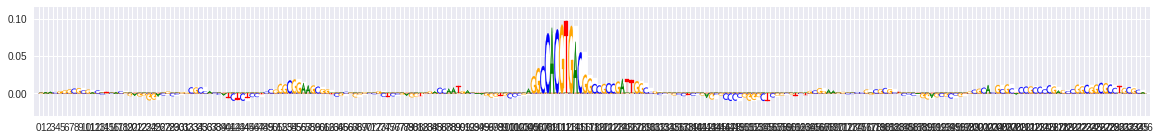

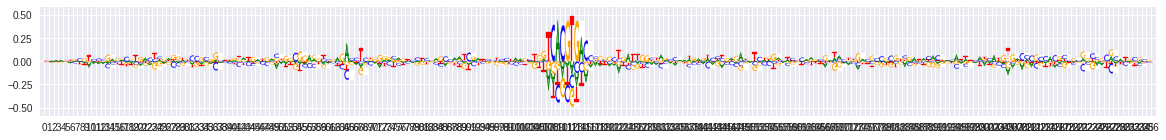

0.49278370521000014


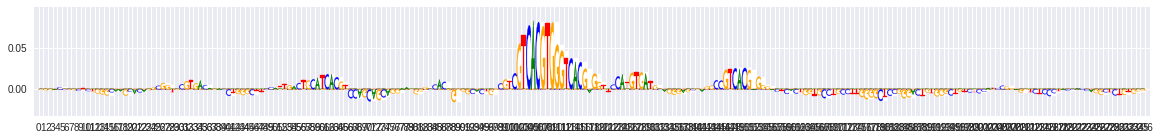

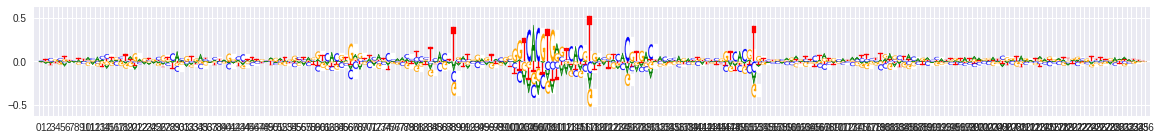

0.36159730199999995


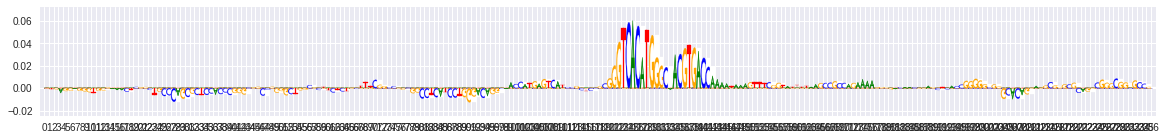

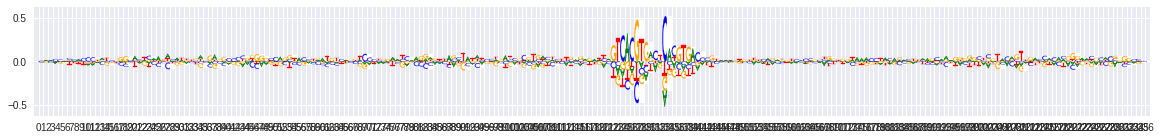

-0.0734240638


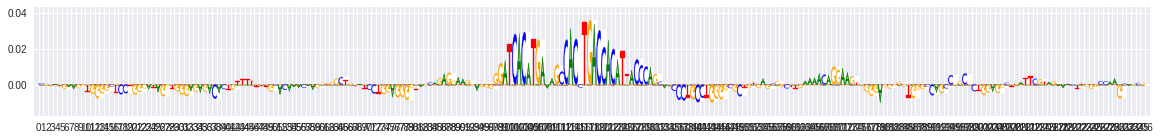

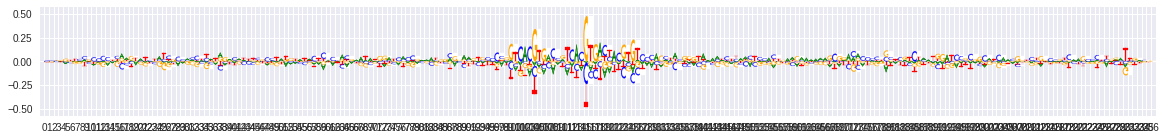

0.8780292366999998


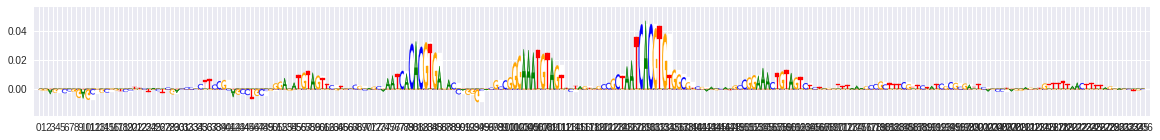

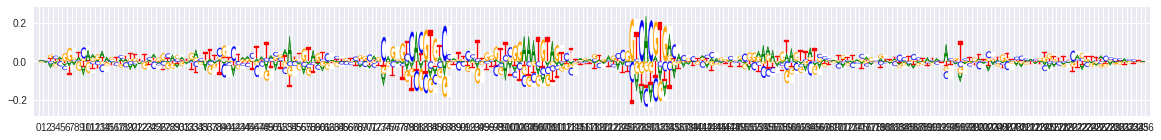

In [11]:
from deeplift.visualization import viz_sequence
for i in range(5):
  print(np.sum(impscores[i]) - 0.379216)
  viz_sequence.plot_weights(impscores[i])
  viz_sequence.plot_weights(hypimpscores[i]-np.mean(hypimpscores[i],axis=1)[:,None])
  assert np.max(np.abs(onehot_data[i]*hypimpscores[i] - impscores[i])) == 0

In [56]:
!rm -rf tfmodisco
!git clone https://github.com/kundajelab/tfmodisco.git
%cd tfmodisco
#!git checkout v0.4.2.1-alpha
!pip install .
%cd ..

Cloning into 'tfmodisco'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 2483 (delta 118), reused 145 (delta 75), pack-reused 2265
Receiving objects: 100% (2483/2483), 30.78 MiB | 34.71 MiB/s, done.
Resolving deltas: 100% (1613/1613), done.
/content/tfmodisco
Processing /content/tfmodisco
  Running setup.py bdist_wheel for modisco ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-wq5ki4ki/wheels/37/3d/e5/59fc9b7e1c93748478a985353f1aaaf721fec5d61bea1ac0f9
Successfully built modisco
  Found existing installation: modisco 0.4.2.2
    Uninstalling modisco-0.4.2.2:
      Successfully uninstalled modisco-0.4.2.2
/content


On task task0
Computing windowed sums
Computing threshold
peak(mu)= 0.013002995534999935
Mu: 1.300300e-02 +/- 8.733910e-07
Lablace_b: 0.0318389051531858 and 0.038019594730367694
Thresholds: -0.16643770000000008 and 0.21586350000000004
#fdrs pass: 0 and 8193
CDFs: 0.9964325136395414 and 0.995183380660427
Est. FDRs: 1.0 and 0.04994633783125104


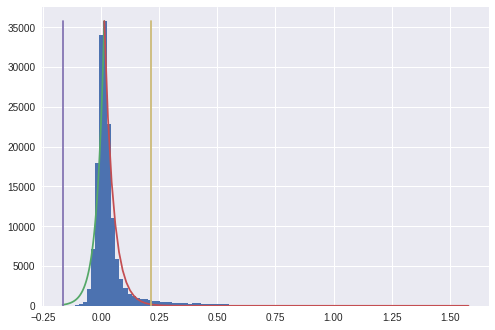

Got 945 coords
After resolving overlaps, got 945 seqlets
Across all tasks, the weakest laplace threshold used was: 0.995183280660427
945 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [944]
Idx to activities:  {0: '1'}
On metacluster 0
Metacluster size 944
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 944
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.9 s
Starting affinity matrix computations
Normalization computed in 0.05 s
Cosine similarity mat computed in 0.22 s
Normalization computed in 0.04 s
Cosine similarity mat computed in 0.21 s
Finished affinity matrix computations in 0.44 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.07 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation job


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.7s finished


Louvain completed 200 runs in 6.367258071899414 seconds
Wrote graph to binary file in 0.4172234535217285 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.877894
Louvain completed 51 runs in 3.374586343765259 seconds
Preproc + Louvain took 10.357948064804077 s
Got 14 clusters after round 1
Counts:
{6: 69, 9: 50, 0: 123, 1: 112, 10: 43, 4: 80, 8: 59, 5: 69, 2: 87, 13: 26, 11: 41, 7: 64, 3: 80, 12: 38}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 123 seqlets
Trimmed 1 out of 123
Aggregating for cluster 1 with 112 seqlets
Trimmed 0 out of 112
Skipped 3 seqlets


/usr/local/lib/python3.6/dist-packages/modisco/core.py:972: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[:,None]),
/usr/local/lib/python3.6/dist-packages/modisco/core.py:974: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[::-1,None]),


Aggregating for cluster 2 with 87 seqlets
Trimmed 14 out of 87
Skipped 1 seqlets
Aggregating for cluster 3 with 80 seqlets
Trimmed 0 out of 80
Aggregating for cluster 4 with 80 seqlets
Trimmed 0 out of 80
Aggregating for cluster 5 with 69 seqlets
Trimmed 3 out of 69
Skipped 1 seqlets
Aggregating for cluster 6 with 69 seqlets
Trimmed 0 out of 69
Aggregating for cluster 7 with 64 seqlets
Trimmed 0 out of 64
Skipped 1 seqlets
Aggregating for cluster 8 with 59 seqlets
Trimmed 2 out of 59
Skipped 1 seqlets
Aggregating for cluster 9 with 50 seqlets
Trimmed 9 out of 50
Skipped 2 seqlets
Aggregating for cluster 10 with 43 seqlets
Trimmed 0 out of 43
Skipped 1 seqlets
Aggregating for cluster 11 with 41 seqlets
Trimmed 6 out of 41
Aggregating for cluster 12 with 38 seqlets
Trimmed 2 out of 38
Aggregating for cluster 13 with 26 seqlets
Trimmed 0 out of 26
Skipped 2 seqlets
(Round 2) num seqlets: 892
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished em

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    5.7s finished


Louvain completed 200 runs in 6.267147541046143 seconds
Wrote graph to binary file in 0.42812633514404297 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.848427
Louvain completed 51 runs in 3.4148330688476562 seconds
Preproc + Louvain took 10.289763927459717 s
Got 11 clusters after round 2
Counts:
{1: 123, 10: 18, 0: 134, 7: 72, 6: 77, 3: 102, 5: 82, 4: 84, 8: 56, 2: 108, 9: 36}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 134 seqlets
Trimmed 20 out of 134
Aggregating for cluster 1 with 123 seqlets
Trimmed 3 out of 123


/usr/local/lib/python3.6/dist-packages/modisco/core.py:972: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[:,None]),
/usr/local/lib/python3.6/dist-packages/modisco/core.py:974: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[::-1,None]),


Aggregating for cluster 2 with 108 seqlets
Trimmed 0 out of 108
Skipped 1 seqlets
Aggregating for cluster 3 with 102 seqlets
Trimmed 0 out of 102
Aggregating for cluster 4 with 84 seqlets
Trimmed 0 out of 84
Skipped 1 seqlets
Aggregating for cluster 5 with 82 seqlets
Trimmed 4 out of 82
Aggregating for cluster 6 with 77 seqlets
Trimmed 2 out of 77
Aggregating for cluster 7 with 72 seqlets
Trimmed 4 out of 72
Aggregating for cluster 8 with 56 seqlets
Trimmed 1 out of 56
Aggregating for cluster 9 with 36 seqlets
Trimmed 0 out of 36
Aggregating for cluster 10 with 18 seqlets
Trimmed 0 out of 18
Got 11 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to binary file in 0.03479433059692383 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.0039749
After 3 runs, maximum modularity is Q = 0.00408507
Louvain completed 23 runs in 1.473015546798706 seconds
Similarity is 0.9812985839994101; is_dissimilar is False
Inspecting f

/usr/local/lib/python3.6/dist-packages/modisco/core.py:972: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[:,None]),
/usr/local/lib/python3.6/dist-packages/modisco/core.py:974: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[::-1,None]),


Trimmed 0 out of 565
Trimmed 0 out of 180
On merging iteration 2
Computing pattern to seqlet distances


/usr/local/lib/python3.6/dist-packages/modisco/core.py:972: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[:,None]),
/usr/local/lib/python3.6/dist-packages/modisco/core.py:974: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[::-1,None]),
/usr/local/lib/python3.6/dist-packages/modisco/core.py:972: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[:,None]),
/usr/local/lib/python3.6/dist-packages/modisco/core.py:974: RuntimeWarning: invalid value encountered in true_divide
  /self.per_position_counts[::-1,None]),


Computing pattern to pattern distances
Collapsing 0 & 2 with prob 6.796632353875978e-06 and sim 0.9192612156690225
Collapsing 0 & 1 with prob 0.002470849932948496 and sim 0.8857102833269238
Aborting collapse as 1 & 2 have prob 9.390326736260863e-08 and sim 0.7780670271267174
Trimmed 0 out of 620
On merging iteration 3
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 0 & 1 with prob 0.002399755545680858 and sim 0.8835681722867251
Trimmed 0 out of 800
On merging iteration 4
Computing pattern to seqlet distances
Computing pattern to pattern distances
Got 4 patterns after merging
Performing seqlet reassignment
Cross contin jaccard time taken: 0.01 s
Cross contin jaccard time taken: 0.01 s
Skipped 7 seqlets
Got 3 patterns after reassignment
Total time taken is 118.04s


In [104]:
from importlib import reload
import modisco

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                        sliding_window_size=6,
                        flank_size=4,
                        seqlets_to_patterns_factory=modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=10,
                        initial_flank_to_add=5,
                        kmer_len=6, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=10),
                        #min_seqlets_per_task is not the actual number of seqlets
                        # that will end up being produced per task, but it
                        # serves as a rough target
                        #The reason for the difference is that many candidate seqlet windows
                        # will get discarded due to overlap with other windows
                        # and it's hard to predict how many
                        #min_seqlets_per_task=2000
                   )(
                task_names=["task0"],
                contrib_scores={'task0': impscores},
                #normalize the hypothetical scores to have a mean of 0 at each
                # position, for ease of visualization
                hypothetical_contribs={'task0': [x-np.mean(x,axis=1)[:,None]
                                                 for x in hypimpscores]},
                one_hot=onehot_data)

num seqlets 794
fwd


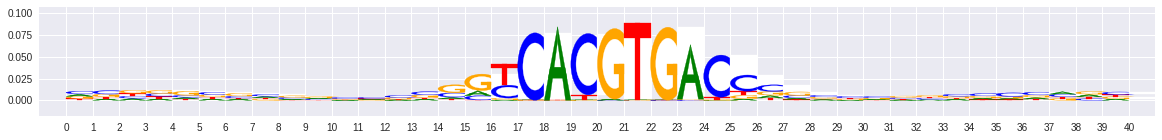

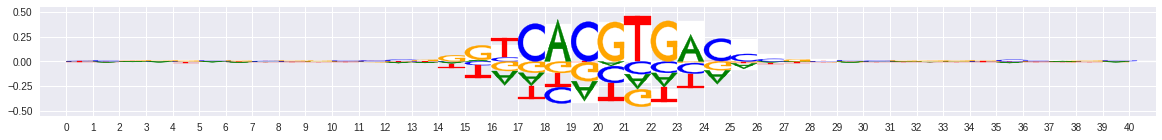

rev


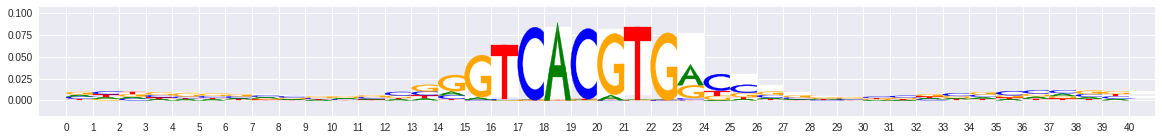

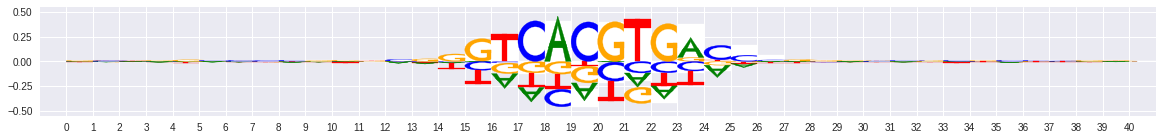

num seqlets 36
fwd


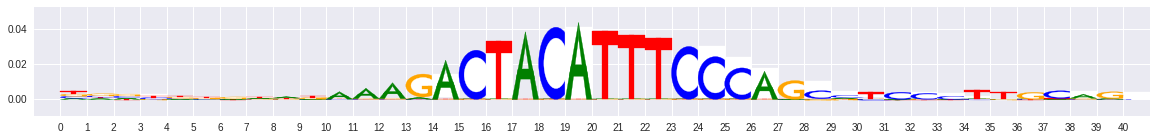

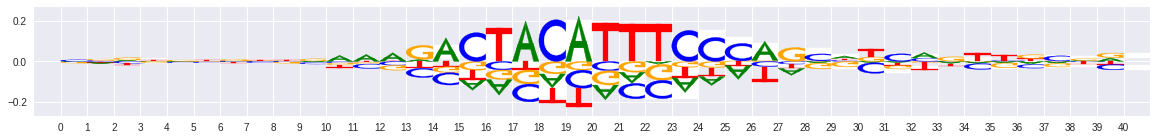

rev


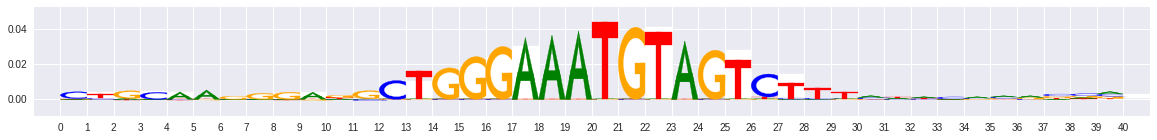

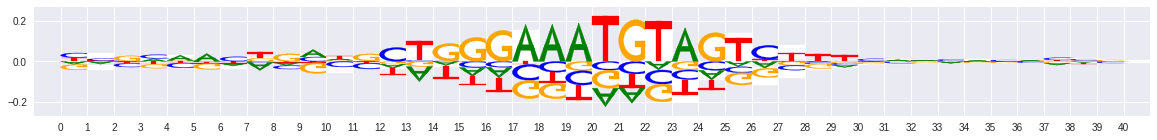

num seqlets 16
fwd


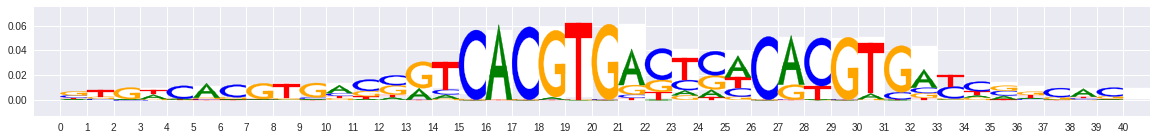

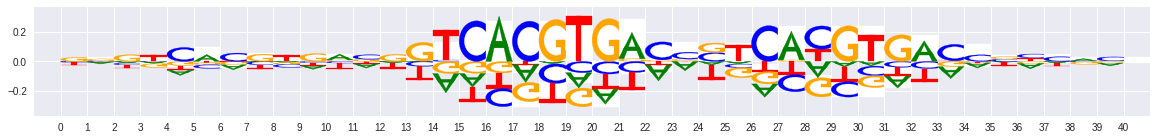

rev


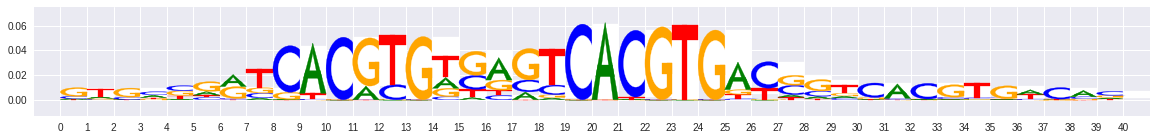

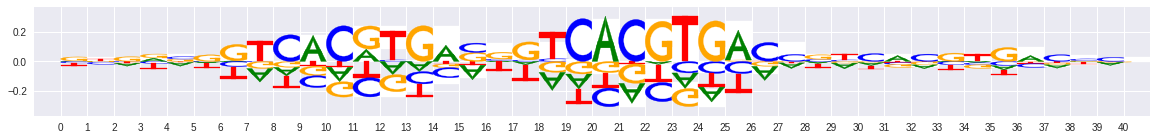

In [110]:
for i,pattern in enumerate(tfmodisco_results.metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result.patterns):
  print("num seqlets",len(pattern.seqlets))
  print("fwd")
  viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
  viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
  print("rev")
  viz_sequence.plot_weights(pattern["task0_contrib_scores"].rev)
  viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)